In [5]:
%matplotlib inline
import tensorflow as tf  # TF2
import numpy as np
import cv2
from enum import Enum, auto, IntEnum
"""
# model data
intercept = 0.01259579
coef = np.array([ 0.01530813, -0.06361941,  0.01532825, -0.06312327,  0.03121793,
       -0.06225985,  0.00515395, -0.06413127,  0.04194056, -0.07163045,
        0.03679023, -0.05856963, -0.01321424, -0.05207514, -0.02547881,
        0.06326243,  0.05637735,  0.10507915, -0.1572394 ,  0.19343185,
        0.04664405,  0.21972535, -0.01213719, -0.00629819,  0.01213719,
        0.00629819, -0.19922164,  0.07706092,  0.19035918,  0.12944567,
       -0.25265423,  0.00517447,  0.22910392,  0.07066526])

"""


interpreter = tf.lite.Interpreter(
    model_path="legwork-model.tflite",
    num_threads=4)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [6]:
test_sample = np.load("legwork.MOV.npy")
test_sample = test_sample.reshape((-1,34))

In [7]:
estimated = []
for pose in test_sample:
    #result = np.exp(np.dot(pose, coef) + intercept)
    #result = result/(1+result)
    interpreter.set_tensor(input_details[0]['index'], pose.reshape(-1,34).astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]['index'])
    result = result[0,0]


    estimated.append(result)

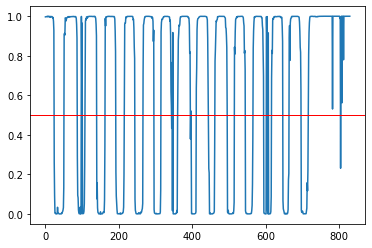

In [8]:
import matplotlib.pyplot as plt


plt.plot(estimated)
plt.axhline(y=0.5, color='r', linewidth=1)
plt.show()


